In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import mplhep as hep
hep.style.use([hep.style.ATLAS])

- implement ATLAS selection
- implement own selection on balanced data
    - correct z0 to delta z0 and var3 to sigma_z0=sqrt(var3_1+var3_2)
- make plot of two histograms (signal and background as a function of score)
- make plot of signal vs background as a function of chosen score cutoff (ATLAS should be (1,1)?)
- make selection for electron pairs require energy (momentum)>10GeV

In [141]:
sample = pd.read_parquet('~/H_Zg/samples_processed/HZeeg_ggF_MC_reduced_Zmodel_eepairs_1Sep_extendedvariables80000_2labels.parquet')

In [142]:
print(sample.shape)
print(sample.columns)

(2336625, 65)
Index(['event_index', 'el_index', 'runNumber', 'eventNumber',
       'actualInteractionsPerCrossing', 'averageInteractionsPerCrossing',
       'm_ee', 'isZ', 'isZnew', 'el1_pt', 'el1_eta', 'el1_phi', 'el1_m',
       'el1_charge', 'el1_ptvarcone20', 'el1_topoetcone20', 'el1_topoetcone40',
       'el1_f1', 'el1_neflowisol20', 'el1_truthPdgId', 'el1_truthType',
       'el1_truthOrigin', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_pel',
       'el1_DFcommonElectrons_LHLoose', 'el1_GSFTrack_d0', 'el1_GSFTrack_z0',
       'el1_GSFTrack_theta', 'el1_GSFTrack_phi', 'el1_GSFTrack_qOverP',
       'el1_GSF_dR', 'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1',
       'el1_GSF_Track_Var2', 'el1_GSF_Track_Var3', 'el1_GSF_Track_Var4',
       'el2_pt', 'el2_eta', 'el2_phi', 'el2_m', 'el2_charge',
       'el2_ptvarcone20', 'el2_topoetcone20', 'el2_topoetcone40', 'el2_f1',
       'el2_neflowisol20', 'el2_truthPdgId', 'el2_truthType',
       'e

In [143]:
ATLAS_label = sample['el1_DFcommonElectrons_LHLoose'] & sample['el2_DFcommonElectrons_LHLoose'] & (np.abs(sample['el1_eta']) < 2.7) & (np.abs(sample['el2_eta']) < 2.7) & (sample['el1_pt'] > 10000) & (sample['el2_pt'] > 10000)
## append ATLAS_label to sample
sample['ATLAS_label'] = ATLAS_label

In [144]:
drop_list = ['isZ', 'isZnew', 'm_ee', 'event_index', 'el_index', 'runNumber', 'eventNumber', 'el1_pt', 'el2_pt'
             , 'el1_truthPdgId', 'el2_truthPdgId', 'el1_truthOrigin', 'el2_truthOrigin', 'el1_truthType', 'el2_truthType',
             'el1_GSFTrack_qOverP', 'el2_GSFTrack_qOverP', 'el1_GSF_Track_Var0', 'el2_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el2_GSF_Track_Var1',
             'el1_GSF_Track_Var2', 'el2_GSF_Track_Var2', 'el1_GSF_Track_Var4', 'el2_GSF_Track_Var4',
             'el1_GSFTrack_theta', 'el2_GSFTrack_theta', 'el1_GSFTrack_phi', 'el2_GSFTrack_phi', 'el1_phi', 'el2_phi'
             , 'el1_DFcommonElectrons_LHLoose', 'el2_DFcommonElectrons_LHLoose']

In [145]:
# mask_GEV = (sample['el1_pt'] > 10000) & (sample['el2_pt'] > 10000)
# ATLAS_label = ATLAS_label[mask_GEV]
# sample = sample[mask_GEV]

In [146]:
isZ = sample[sample['isZnew'] == 1]
isNotZ = sample[sample['isZnew'] == 0]
isNotZ_sampled = isNotZ.sample(frac=0.01, random_state=42) 
small_sample = pd.concat([isZ, isNotZ_sampled])

print(f'full sample size:{len(sample)}, number of Z:{len(isZ)}, number of not Z:{len(isNotZ)}')
print(f'small sample size:{len(small_sample)}, number of Z:{len(isZ)}, number of not Z:{len(isNotZ_sampled)}')


full sample size:2336625, number of Z:18811, number of not Z:2317814
small sample size:41989, number of Z:18811, number of not Z:23178


no


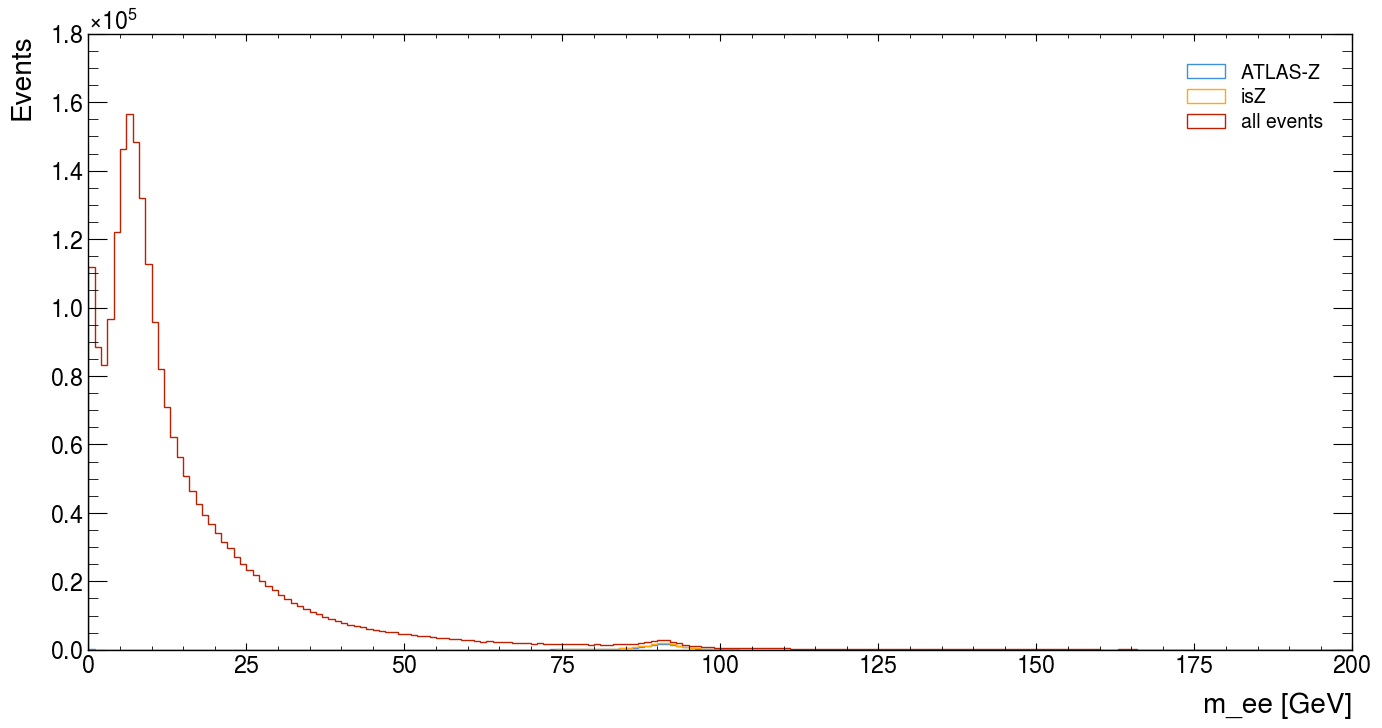

In [147]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(sample['m_ee'][ATLAS_label==1], bins=200, range=(0, 200), histtype='step', label='ATLAS-Z')
ax.hist(sample['m_ee'][sample['isZnew']==1], bins=200, range=(0, 200), histtype='step', label='isZ')
ax.hist(sample['m_ee'], bins=200, range=(0, 200), histtype='step', label='all events')
ax.set_xlabel('m_ee [GeV]')
ax.set_ylabel('Events')
ax.legend()
# ax.set_title('ATLAS label')
print('no')

In [148]:
input_data = small_sample.drop(drop_list, axis=1)
truth_data = small_sample['isZ']

In [149]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

r = np.random
r.seed(12)

X_train, X_test, y_train, y_test = train_test_split(input_data, truth_data, test_size=0.25, random_state=12)

In [150]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 0, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1,log=True),
        'drop_rate': trial.suggest_float('drop_rate', 0.005, 0.4),
        'verbose': 0
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-09-02 18:55:51,014] A new study created in memory with name: no-name-997bad4c-d4df-4135-9d6b-eda8570da629


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_col_wise=true` to remove the overhead.


[W 2024-09-02 18:55:51,732] Trial 0 failed with parameters: {'max_depth': 13, 'num_leaves': 116, 'learning_rate': 0.002531711556566766, 'drop_rate': 0.07735085491303806} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/lustre/hpc/hep/kinch/python/initenv/lib64/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2891121/2474603781.py", line 14, in objective
    gbm = lgb.train(param, dtrain)
  File "/lustre/hpc/hep/kinch/python/initenv/lib64/python3.9/site-packages/lightgbm/engine.py", line 266, in train
    booster.update(fobj=fobj)
  File "/lustre/hpc/hep/kinch/python/initenv/lib64/python3.9/site-packages/lightgbm/basic.py", line 3557, in update
    _safe_call(_LIB.LGBM_BoosterUpdateOneIter(
KeyboardInterrupt
[W 2024-09-02 18:55:51,762] Trial 0 failed with value None.


KeyboardInterrupt: 

In [ ]:
print('Best value:', study.best_value)
print('Best parameters:', study.best_params)

Best value: 0.9974732268310249
Best parameters: {'max_depth': 70, 'num_leaves': 26, 'learning_rate': 0.09986370370985571, 'drop_rate': 0.026259501696149497}


In [ ]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 13781, number of negative: 17710
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6262
[LightGBM] [Info] Number of data points in the train set: 31491, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437617 -> initscore=-0.250839
[LightGBM] [Info] Start training from score -0.250839


LGBMClassifier(drop_rate=0.026259501696149497,
               learning_rate=0.09986370370985571, max_depth=70, num_leaves=26)

Text(0.5, 1.0, 'Receiver operating characteristic')

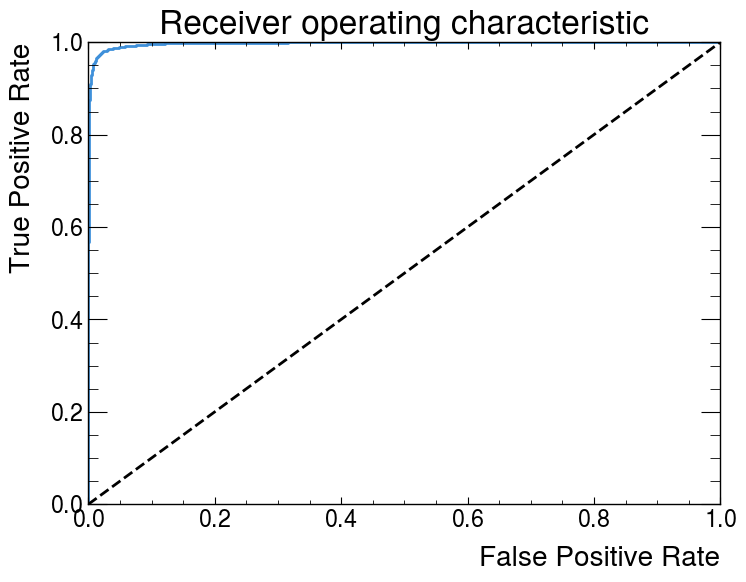

In [ ]:
# roc curve

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:0.2e})')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')


In [ ]:
scores = model.predict_proba(input_data)[:,1]
model_prediction = model.predict(input_data)

no


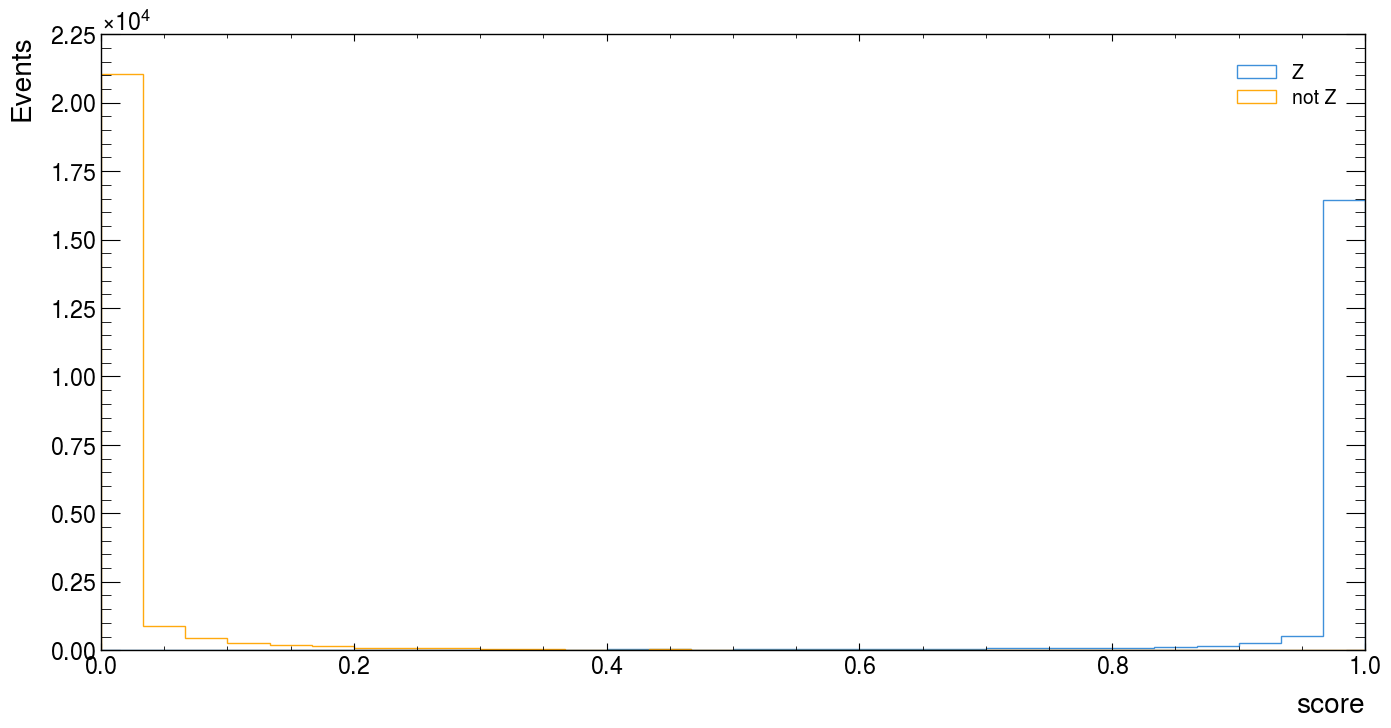

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(scores[truth_data==1], bins=30, range=(0, 1), histtype='step', label='Z')
ax.hist(scores[truth_data==0], bins=30, range=(0, 1), histtype='step', label='not Z')
ax.set_xlabel('score')
ax.set_ylabel('Events')
ax.legend()

print('no')

Text(0, 1, 'S/B')

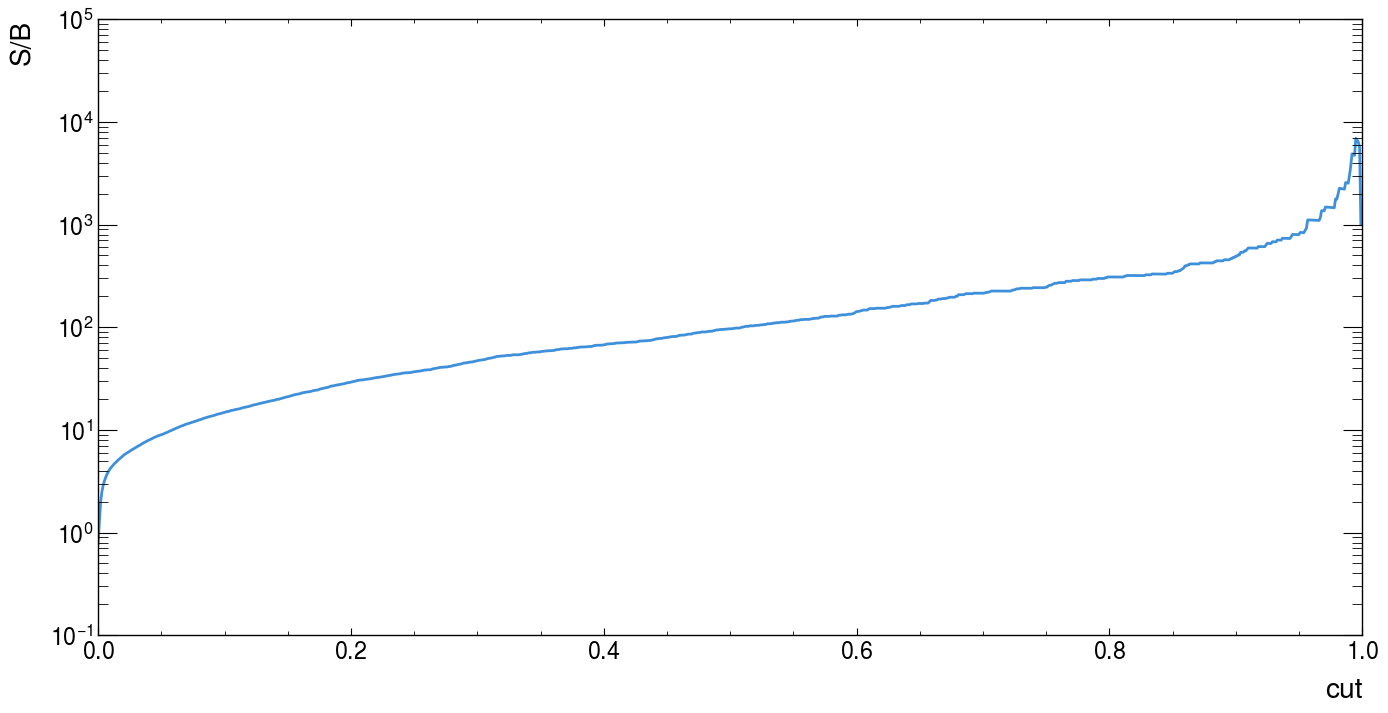

In [ ]:
N = 1000
p = np.linspace(0, 1-1/N, 1000-1)
eff = []

for i in p:
    if len(scores[(scores > i) & (truth_data == 0)]) == 0:
        signaltobck = 1e3
    else:
        signaltobck = len(scores[(scores > i) & (truth_data == 1)]) / len(scores[(scores > i) & (truth_data == 0)])
    eff.append(signaltobck)

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(p, eff)
ax.set_yscale('log')
ax.set_xlabel('cut')
ax.set_ylabel('S/B')

no


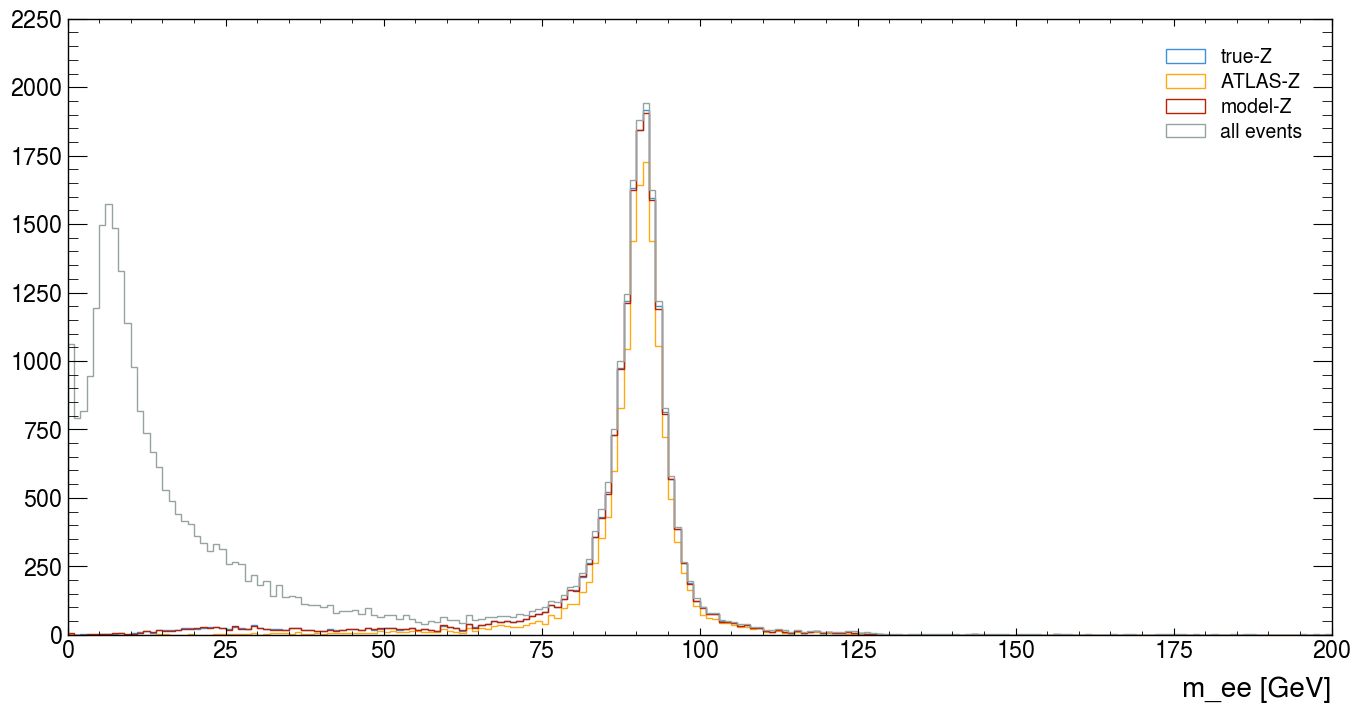

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(small_sample['m_ee'][truth_data==1], bins=200, range=(0, 200), histtype='step', label='true-Z')
# ax.hist(small_sample['m_ee'][truth_data==0], bins=200, range=(0, 200), histtype='step', label='non-Z')
counts_atlas = ax.hist(small_sample['m_ee'][ATLAS_label==1], bins=200, range=(0, 200), histtype='step', label='ATLAS-Z')
counts_model = ax.hist(small_sample['m_ee'][model_prediction==1], bins=200, range=(0, 200), histtype='step', label='model-Z')
ax.hist(small_sample['m_ee'], bins=200, range=(0, 200), histtype='step', label='all events')
ax.set_xlabel('m_ee [GeV]')
ax.legend()
print('no')

Text(1, 0, 'm_ee [GeV]')

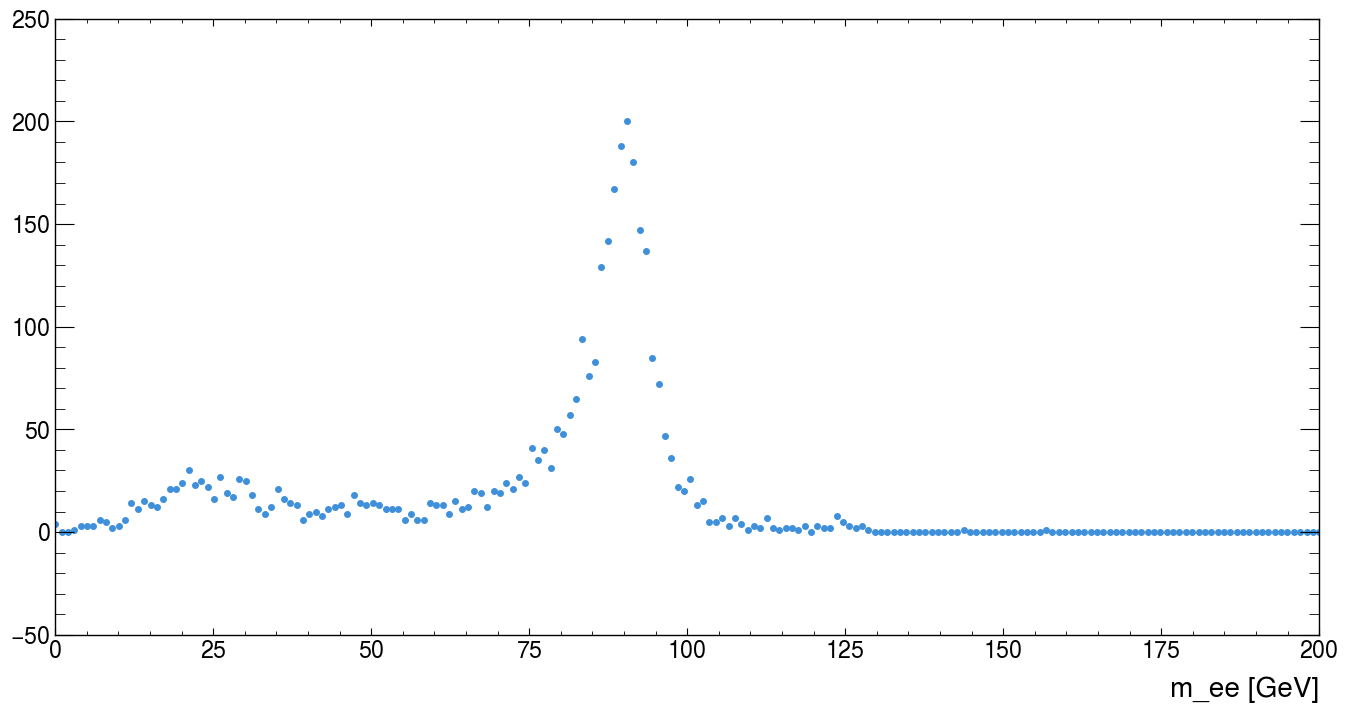

In [ ]:
difference_modelvsatlas = counts_model[0] - counts_atlas[0]
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(np.linspace(0,200,200),difference_modelvsatlas,'.', label='model - ATLAS')
ax.set_xlabel('m_ee [GeV]')

In [ ]:
wewinatlaslose = (model_prediction==truth_data) & (ATLAS_label != truth_data)

ValueError: Can only compare identically-labeled Series objects